In [ ]:
!pip install rasterio raster2xyz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.2 MB/s eta 0:00:00
  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5946 sha256=86a2164bf12cd6ea4066d799c248dca4b0637bd534cc477862ddd422f48e688b
  Stored in directory: /root/.cache/pip/wheels/ef/5e/51/6df10cfc8d97148b3f46dd034ff2d748748d3b70ec53fbee69
Successfully built raster2xyz


In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# LDA Imports
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.patches as mpatches


In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

############## Update your 'mainDir' if your utlizing my code!!! ###############
# mainDir = "/content/drive/My Drive/.School/Capstone/"
################################################################################

################################################################################
# Using Shared Directory
# Be careful not to override others Checkpoints! => Make unique to your name
################################################################################
# Example:
# checkpoint_path = mainDir + 'model_checkpoints_{Your_Name_Here}/my_weights.weights.h5'
mainDir = "/content/drive/Shareddrives/Land_Classification_Training_shared/Land_Classification_training_work/"
################################################################################

# Define file paths
images_path = mainDir + "avirisng_sample_subset"
samples_path = mainDir + "valid_samples_1d/samples_3.csv" # Updated to use most recent samples

# NOTE: Only has final class name & Sample_num in this copy
labels_path = mainDir + "valid_samples_1d/Majority_Labeling_Cleaned.csv"

# DEFINE YOUR MODEL CHECKPOINT

# MY MODEL CHECKPOINT, PLEASE DO NOT USE IF TRAINING, ONLY FOR LOADING
################################################################################
checkpoint_path = mainDir + 'model_checkpoints_Ian/my_weights.weights.h5'
checkpoint_path_class_weights = mainDir + 'model_checkpoints_Ian/my_weights_with_cw.weights.h5'
################################################################################



# checkpoint_path = mainDir + '{YOUR_CHECKPOINT_PATH}'

Mounted at /content/drive


In [ ]:
def load_data(samples_path, labels_path):
  samples_df = pd.read_csv(samples_path)
  labels_df = pd.read_csv(labels_path)
  return samples_df, labels_df

In [ ]:
def preprocess_data(samples_df, labels_df):
  # Extract sample number
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

  # Clean up labels in both DataFrames (removing the extras in the names (e.g wheat)...)
  labels_df['Class'] = labels_df['Class'].str.split('(').str[0].str.strip()
  samples_df['Label'] = samples_df['Label'].str.split('(').str[0].str.strip()

  # Remove rows with "Mixed or Not Classified" (Assuming this was the plan)
  samples_df = samples_df[samples_df['Label'] != 'Mixed or Not Classified']
  labels_df = labels_df[labels_df['Class'] != 'Mixed or Not Classified']

  # Filter labels_df to include only Sample_num values present in samples_df
  labels_df = labels_df[labels_df['Sample_num'].isin(samples_df['Sample_num'])]

  # Reset the index to be consecutive after removing "Mixed or Not Classified"
  samples_df.reset_index(drop=True, inplace=True)
  labels_df.reset_index(drop=True, inplace=True)

  # Make syre of the unique labels after cleaning
  assert set(samples_df['Label'].unique()) == set(labels_df['Class'].unique()), "Mismatch in unique labels between samples_df and labels_df"

  # Define frequency columns for targeted NaN replacement
  frequency_columns = [col for col in samples_df.columns if col.startswith('frq')]

  # Make all those found with NaN's to be changed to -9999.000..
  samples_df.loc[:, frequency_columns] = samples_df[frequency_columns].fillna(-9999)

  # Filter out rows where all values in frequency columns are -9999
  filtered_samples_df = samples_df[~samples_df[frequency_columns].eq(-9999).all(axis=1)]

  # Make sure labels_df are aligned properly by keeping only matching Sample_num values
  filtered_samples_df = filtered_samples_df[filtered_samples_df['Sample_num'].isin(labels_df['Sample_num'])]

  # Filter out rows where all values in frequency columns are -9999
  filtered_samples_df = samples_df[~samples_df.filter(like='frq').eq(-9999).all(axis=1)]

  # Make sure filtered samples_df and labels_df are matching up by keeping only matching Sample_num
  filtered_samples_df = filtered_samples_df[filtered_samples_df['Sample_num'].isin(labels_df['Sample_num'])]

  # Check that all NaNs in frequency columns have been replaced
  nan_counts = filtered_samples_df[frequency_columns].isna().sum().sum()
  assert(nan_counts == 0)  # Should be 0 if all NaNs were replaced

  # Check for -9999 in the dataframe
  count_negative_9999 = (filtered_samples_df == -9999).sum().sum()
  assert(count_negative_9999 == 0)

  # Make a copy of samples_df to avoid Warnings after filtering
  samples_df = samples_df.copy()

  # Label Encoding for consistency
  label_encoder = LabelEncoder()
  samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

  return samples_df, labels_df

In [ ]:
def map_ground_truth(filtered_samples_df, labels_df):
  # Extract Sample_num from File column
  filtered_samples_df['Extracted_Sample_num'] = filtered_samples_df['File'].str.split('_').str[0].astype(int)

  # Create a mapping dict from labels_df using Sample_num and Class
  sample_class_mapping = labels_df.set_index('Sample_num')['Class'].to_dict()

  # Map Class values to filtered_samples_df based on Extracted_Sample_num
  filtered_samples_df['Ground_Truth'] = filtered_samples_df['Extracted_Sample_num'].map(sample_class_mapping)

  # Find mismatches between Label and Ground_Truth
  mismatches = filtered_samples_df[filtered_samples_df['Label'] != filtered_samples_df['Ground_Truth']]

  # Group by Extracted_Sample_num and Label to get count of pixels for each
  pixel_counts_df = filtered_samples_df.groupby(['Extracted_Sample_num', 'Label']).size().reset_index(name='Pixel_Count')

  # Merge the Ground_Truth based on Extracted_Sample_num
  pixel_counts_df = pixel_counts_df.merge(
      filtered_samples_df[['Extracted_Sample_num', 'Ground_Truth']].drop_duplicates(),
      on='Extracted_Sample_num',
      how='left'
    )

  return pixel_counts_df, mismatches

In [ ]:
def verify_data_alignment(filtered_samples_df, labels_df, pixel_counts_df, mismatches, frequency_columns):
  """
  Verifies the alignment and consistency of data between filtered_samples_df, labels_df, and pixel_counts_df.
  Reports test status (pass/fail) for each verification step.
  """
  # Store test results
  test_results = []

  # Test 1: Make sure there are no mismatches between Label and Ground_Truth
  try:
      assert mismatches.empty, "Mismatches found between Label and Ground_Truth."
      test_results.append("Test 1: No mismatches between Label and Ground_Truth - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 1: {str(e)} - FAILED :(")

  # Test 2: Make sure their are no missing Sample_num values in pixel_counts_df
  missing_in_pixel_counts = set(labels_df['Sample_num']) - set(pixel_counts_df['Extracted_Sample_num'])
  try:
      assert len(missing_in_pixel_counts) == 0, "Sample_num values in labels_df but not in pixel_counts_df."
      test_results.append("Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 2: {str(e)} - FAILED :(")

  # Test 3: Make sure their are no missing Sample_num values in original samples_df
  missing_samples_check = filtered_samples_df[filtered_samples_df['Sample_num'].isin(missing_in_pixel_counts)]
  try:
      assert missing_samples_check.empty, "Entries in samples_df for missing Sample_num values."
      test_results.append("Test 3: No missing Sample_num values in samples_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 3: {str(e)} - FAILED :(")

  # Test 4: Check if missing Sample_num values were filtered out due to all -9999 values in frequency columns
  filtered_out_all_9999 = filtered_samples_df[
      filtered_samples_df['Sample_num'].isin(missing_in_pixel_counts) &
      filtered_samples_df[frequency_columns].eq(-9999).all(axis=1)
  ]
  try:
      assert filtered_out_all_9999.empty, "Entries filtered out due to all -9999 values."
      test_results.append("Test 4: No entries filtered out due to all -9999 values - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 4: {str(e)} - FAILED :(")

  # Test 5: Make sure the unique Sample_num counts between labels_df and filtered_samples_df are equal
  valid_sample_nums = filtered_samples_df['Sample_num'].unique()
  filtered_labels_df = labels_df[labels_df['Sample_num'].isin(valid_sample_nums)].reset_index(drop=True)
  try:
      assert filtered_labels_df['Sample_num'].nunique() == filtered_samples_df['Sample_num'].nunique(), (
          "Mismatch in unique Sample_num count between labels_df and filtered_samples_df."
      )
      test_results.append("Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 5: {str(e)} - FAILED :(")

  # Results
  print("\nVerification Results:")
  for result in test_results:
      print(result)

In [ ]:
samples_df, labels_df = load_data(samples_path, labels_path)

In [ ]:
samples_df

,Unnamed: 0,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,...,frq366,frq367,frq368,frq369,frq370,frq371,frq372,Label,Shape,File
0,0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,...,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,Unconsolidated Barren,"(10, 10)",1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,...,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,Unconsolidated Barren,"(10, 10)",1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,...,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,Unconsolidated Barren,"(10, 10)",1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,...,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,Unconsolidated Barren,"(10, 10)",1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,...,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,Unconsolidated Barren,"(10, 10)",1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300033,59,0.046806,0.051411,0.059857,0.063429,0.066798,0.071768,0.072838,0.076341,0.080804,...,0.012441,0.014959,0.019577,0.011943,0.015404,0.021072,0.027756,Waterbodies,"(8, 8)",12128_ang20231031t092656_025_L2A_OE_main_27577...
300034,60,0.046862,0.052788,0.061928,0.065137,0.069281,0.072774,0.073955,0.078714,0.082927,...,0.016511,0.012616,0.015370,0.018824,0.028074,0.047163,0.031902,Waterbodies,"(8, 8)",12128_ang20231031t092656_025_L2A_OE_main_27577...
300035,61,0.044689,0.049277,0.055507,0.061436,0.064873,0.068337,0.069823,0.074879,0.078751,...,0.012599,0.012702,0.017404,0.018361,0.018821,0.030842,0.078079,Waterbodies,"(8, 8)",12128_ang20231031t092656_025_L2A_OE_main_27577...
300036,62,0.047958,0.051963,0.058101,0.065782,0.067146,0.070770,0.073709,0.077327,0.081112,...,0.014440,0.018656,0.015339,0.018846,0.030422,0.048251,0.034640,Waterbodies,"(8, 8)",12128_ang20231031t092656_025_L2A_OE_main_27577...


In [ ]:
labels_df

,Class,Sample_num
0,Unconsolidated Barren,1
1,Unconsolidated Barren,2
2,"Consolidated Barren (rocks, salt pans)",3
3,Annual Crops (e.g wheat),4
4,Annual Crops (e.g wheat),5
...,...,...
1805,Waterbodies,12048
1806,Waterbodies,12092
1807,Waterbodies,12108
1808,Waterbodies,12116


In [ ]:
# Preprocess Data
samples_df, labels_df = preprocess_data(samples_df, labels_df)

# Encode labels in the 'Label' column
label_encoder = LabelEncoder()
samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]
X = samples_df[frequency_cols].values  # 2D array where each row is a pixel's spectral data
y = samples_df['Label']  # Use the filtered Ground Truth labels for each pixel

# Encode Ground_Truth labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Model params
# input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, X_test.shape)  # Should show (num_train_samples, num_features)
print(y_train_cat.shape, y_test_cat.shape)  # Should show (num_train_samples, num_classes)

(219949, 373) (54988, 373)
(219949, 11) (54988, 11)


In [ ]:
print(X_train[:10])

[[ 1.88712980e-02  1.88955570e-02  3.08231200e-02 ...  1.80683510e-01
   1.85997070e-01  1.91549580e-01]
 [ 1.35063530e-02  1.42206620e-02  1.39062030e-02 ...  9.39072300e-02
   9.59895550e-02  9.79213200e-02]
 [-3.51114700e-03  2.58666440e-03  4.74144940e-03 ...  1.48296630e-02
  -7.82025500e-02  2.10932240e-01]
 ...
 [ 2.87105220e-02  2.96189060e-02  3.70103680e-02 ...  3.72508900e-01
   3.53419240e-01  4.05541180e-01]
 [-6.83084800e-03  2.83368700e-03  2.14688220e-03 ... -1.91444320e-05
  -6.20013030e-02 -8.99430000e-02]
 [ 1.60931550e-02  1.79725120e-02  1.95923130e-02 ...  1.13865380e-01
   1.18194970e-01  1.22171685e-01]]


In [ ]:
# Flatten a 3D array (samples, features, channels) into 2D (samples, features * channels)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print("Variance before scaling:", np.var(X_train_flattened, axis=0))

Variance before scaling: [4924823.33512939 4924826.43079407 4924829.72889935 4924832.72094298
 4924835.37520863 4924837.43062426 4924839.01932289 4924840.94526657
 4924843.28700911 4924845.4340556  4924847.38916469 4924849.43061981
 4924851.84651809 4924853.24543582 4924854.40270745 4924855.78808986
 4924856.77933339 4924858.31233769 4924859.50154257 4924860.89942542
 4924862.15940651 4924863.4889772  4924864.7938702  4924866.42527671
 4924868.3866788  4924869.89953559 4924872.13131436 4924874.95768807
 4924877.84995052 4924880.28113022 4924882.17822059 4924884.45681495
 4924886.37120084 4924887.86554353 4924889.527133   4924890.99403789
 4924892.25159434 4924892.91858417 4924892.87391424 4924893.42553105
 4924894.62057264 4924895.83186555 4924896.71878343 4924897.47453562
 4924898.31240145 4924898.9018912  4924899.17072794 4924899.93489595
 4924900.6331834  4924901.62353352 4924902.1727454  4924902.78000694
 4924902.87762987 4924903.30234632 4924903.25255983 4924902.79181088
 4924903.

In [ ]:
print(X_train_flattened.shape)

(219949, 373)


In [ ]:
X_test_flattened.shape

(54988, 373)

In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_encoded = to_categorical(y_test, num_classes=len(label_encoder.classes_))


In [ ]:
y_train_encoded.shape

(219949, 11)

In [ ]:
y_test_encoded.shape

(54988, 11)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax
])

# Compile the model with categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:


# Train the model
history = model.fit(
    X_train,
    y_train_encoded,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=50,            # Number of epochs to train
    batch_size=32         # Number of samples per gradient update
)


Epoch 1/50


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flattened.shape[1],)),  # 373 input features
    Dense(64, activation='relu'),  # Additional hidden layer
    Dense(11, activation='softmax')  # Output layer with 11 units for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_flattened,
    y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_flattened, y_test_encoded),
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5704 - loss: 45.0944 - val_accuracy: 0.6353 - val_loss: 1.2812
Epoch 2/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6511 - loss: 1.4097 - val_accuracy: 0.6702 - val_loss: 0.9845
Epoch 3/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6617 - loss: 1.3604 - val_accuracy: 0.6721 - val_loss: 0.9340
Epoch 4/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6753 - loss: 0.9514 - val_accuracy: 0.6950 - val_loss: 0.8797
Epoch 5/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6883 - loss: 1.3408 - val_accuracy: 0.6950 - val_loss: 0.8801
Epoch 6/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6946 - loss: 0.9158 - val_accuracy: 0.7080 - val_loss: 0.8355
Epoch 7/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7024 - loss: 0.8646 - val_accuracy: 0.7067 - val_loss: 0.8266
Epoch 8/50
6874/6874 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7077 - loss: 

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_flattened, y_test_encoded)

# Print the test results
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7810 - loss: 0.5858
Test Loss: 0.5899645686149597, Test Accuracy: 0.7805703282356262


In [ ]:
# Predict the probabilities for each class
predictions = model.predict(X_test_flattened)

# Get the predicted class labels by finding the index of the highest probability
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Print the predicted labels
print(predicted_labels)
predicted_labels

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
['Shrubs' 'Planted Forest' 'Natural Grassland' ... 'Permanent Crops'
 'Shrubs' 'Built-up']


array(['Shrubs', 'Planted Forest', 'Natural Grassland', ...,
       'Permanent Crops', 'Shrubs', 'Built-up'], dtype=object)

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Extract features and labels
frequency_cols = [col for col in samples_df.columns if 'frq' in col]
X = samples_df[frequency_cols].values
y = samples_df['Label']  # Use the cleaned labels

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Apply LDA
lda = LDA(n_components=None)  # Set n_components to None to retain all discriminative features
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Train a classifier (e.g., Random Forest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_lda, y_train)

# Make predictions
y_pred = clf.predict(X_test_lda)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Explained variance ratio for LDA components
explained_variance = lda.explained_variance_ratio_
print("Explained Variance Ratio per Component:", explained_variance)


Classification Report:
                        precision    recall  f1-score   support

         Annual Crops       0.64      0.65      0.65      7481
             Built-up       0.64      0.42      0.51      3170
  Consolidated Barren       0.53      0.34      0.41      4424
    Natural Grassland       0.46      0.24      0.31      3296
  Natural Wooded Land       0.59      0.54      0.56      7253
      Permanent Crops       0.53      0.30      0.38       742
       Planted Forest       0.40      0.18      0.25      1172
               Shrubs       0.60      0.81      0.69     19481
Unconsolidated Barren       0.65      0.48      0.55      1652
          Waterbodies       0.98      0.93      0.96      6131
             Wetlands       0.77      0.46      0.57       186

             accuracy                           0.64     54988
            macro avg       0.62      0.49      0.53     54988
         weighted avg       0.63      0.64      0.62     54988

Accuracy Score: 0.6398668800

### Explanation

1. Classification Report
The classification report provides metrics for evaluating the model's performance for each class.

Key Metrics:
Precision: The proportion of true positive predictions out of all positive predictions for a class.

Example: For Annual Crops, the precision is 0.64, meaning 64% of predictions for this class were correct.
Recall: The proportion of true positives out of all actual instances of a class.

Example: Shrubs has a recall of 0.81, indicating that 81% of actual Shrubs instances were correctly identified.
F1-Score: Harmonic mean of precision and recall; balances the two metrics.

Example: Waterbodies has an f1-score of 0.96, showing excellent overall performance for this class.
Support: The number of actual instances for each class.

Example: Built-up has a support of 3170, meaning there are 3170 samples of this class in the dataset.
Observations:
High Performance:

Classes like Waterbodies and Shrubs perform well, with high precision, recall, and f1-scores. This suggests that the LDA transformation effectively separates these classes.
Low Performance:

Classes like Planted Forest and Natural Grassland have low recall and f1-scores, indicating misclassification. These classes may overlap significantly in feature space.
Imbalanced Support:

Some classes (e.g., Wetlands with support of 186) have far fewer samples, leading to lower performance due to data imbalance.
2. Accuracy Score
The overall accuracy of 63.99% indicates that approximately 64% of all samples were correctly classified. While this is moderate, further improvements could be made by:

Balancing the dataset (e.g., using oversampling or undersampling techniques).
Using additional features or improving feature engineering.
Exploring advanced classifiers beyond the current LDA-based pipeline.
3. Explained Variance Ratio per Component
The explained variance ratio indicates how much of the dataset's total variance each LDA component captures. These values represent the "importance" of each LDA component.

Values:
Component 1: 85.88% of the variance.
Component 2: 10.37% of the variance.
Component 3: 3.67% of the variance.
Component 4: 0.08% of the variance.
Interpretation:
Dominance of Component 1:

The first component explains most of the variance (85.88%), suggesting that the data is heavily separable along this axis. This aligns with LDA's goal of maximizing class separability.
Diminishing Returns:

Subsequent components add diminishing amounts of variance. By the fourth component, the contribution is negligible (0.08%).
Implications:
Dimensionality Reduction:
Using just the first 2-3 components might retain sufficient information for classification, simplifying the model.
Class Overlap:
Classes with low performance in the classification report might overlap even along the major components, contributing to misclassifications.
Summary
Strengths: Good separation for certain classes (Shrubs, Waterbodies). High explained variance by the first component shows LDA captures key features.
Weaknesses: Poor recall for some classes (Planted Forest, Natural Grassland) due to overlap or insufficient data.
Next Steps: Improve class separability using advanced techniques like:
Balancing the dataset.
Adding or transforming features.
Testing other models (e.g., Random Forest, SVM).

### Visualization

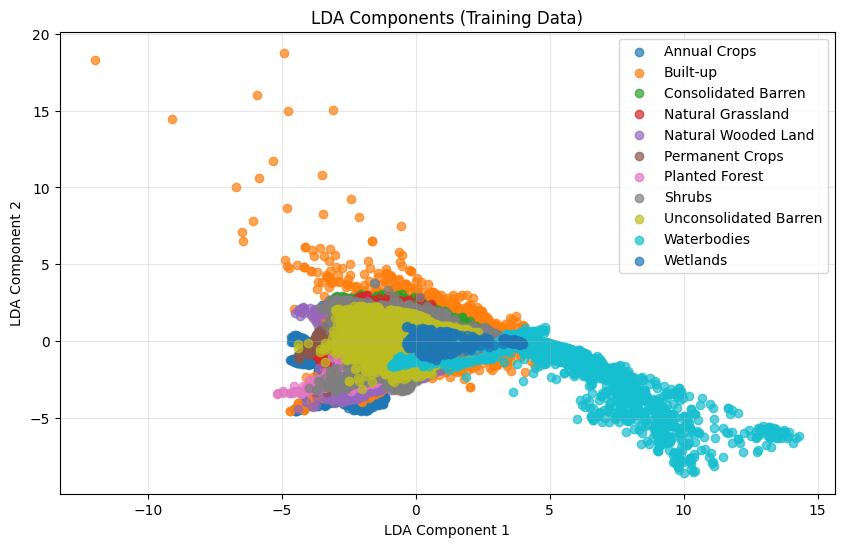

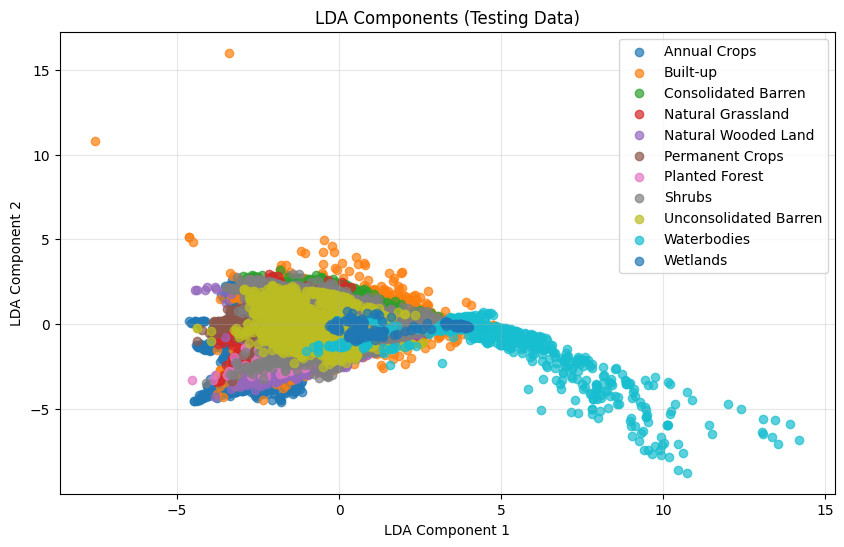

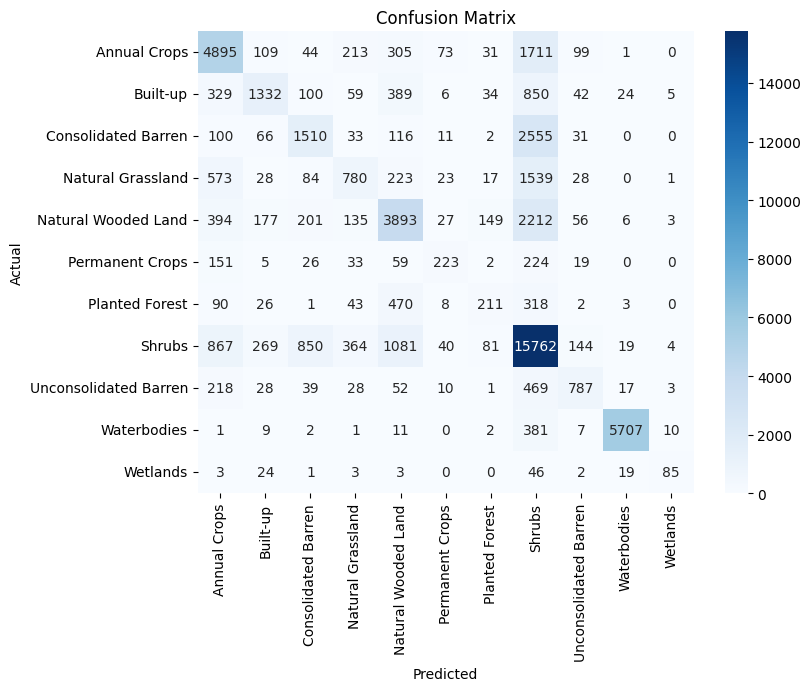

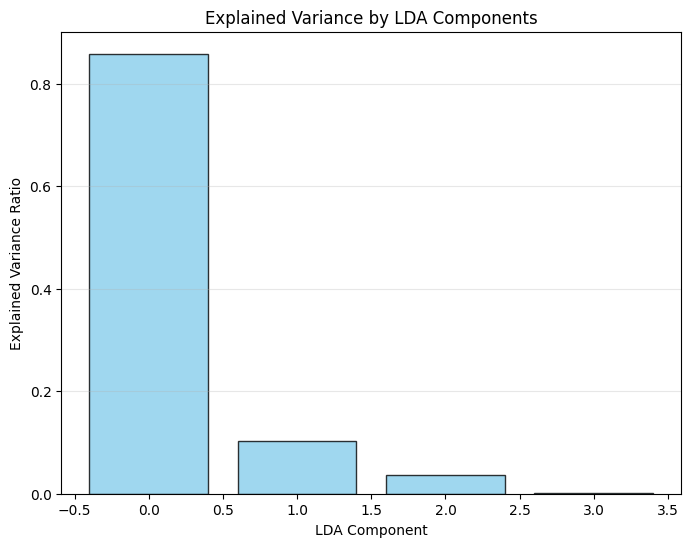

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualize LDA components
def plot_lda_components(X_lda, y, title, label_encoder):
    plt.figure(figsize=(10, 6))
    unique_classes = sorted(set(y))
    for class_label in unique_classes:
        plt.scatter(
            X_lda[y == class_label, 0],
            X_lda[y == class_label, 1],
            label=label_encoder.inverse_transform([class_label])[0],
            alpha=0.7
        )
    plt.title(title)
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

# Plot training data LDA components
plot_lda_components(X_train_lda, y_train, "LDA Components (Training Data)", label_encoder)

# Plot testing data LDA components
plot_lda_components(X_test_lda, y_test, "LDA Components (Testing Data)", label_encoder)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Explained Variance Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(explained_variance)), explained_variance, color='skyblue', alpha=0.8, edgecolor='k')
plt.title("Explained Variance by LDA Components")
plt.xlabel("LDA Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(axis='y', alpha=0.3)
plt.show()


#### Attempt at transfer Learning Using RESNET

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

# Assuming X_train and X_test are loaded and in the shape (219949, 373, 1)
X_train = X_train.reshape((X_train.shape[0], 373, 1, 1))  # For grayscale images
X_test = X_test.reshape((X_test.shape[0], 373, 1, 1))  # For grayscale images

# Normalize images using ResNet's preprocessing
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=11)
y_test_encoded = to_categorical(y_test, num_classes=11)

# Load ResNet50 model pre-trained on ImageNet without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(373, 1, 3))

# Freeze all layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for landscape classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the output to create a vector
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(11, activation='softmax')(x)  # Output layer with 11 classes

# Define the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training data generator
train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=32)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=(X_test, y_test_encoded),
    verbose=1
)


IndexError: index 1 is out of bounds for axis 3 with size 1